In [ ]:
__author__ = 'Alex Moss'
"""
Assignment #4 - Image Analytics for GDA
The aim of assignment 4 is to analyse crop yield using the NDVI vegetation 
index. This will be done on a broad scale using low spatial resolution data. 
While the data will have a low spatial resolution of 1 km, the sensor has a 
high temporal resolution. This allows compositing to be applied to the data to 
counter the effects of cloud cover.
"""

In [1]:
import rasterio
import pyproj
import os
import numpy as np
import shapely
import json
from rasterio.warp import calculate_default_transform, reproject, Resampling
from zipfile import ZipFile
import rasterio.mask
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely.geometry import shape, mapping
from shapely.ops import transform
from rasterio.transform import Affine
from shapely.geometry import box
import glob
from scipy.integrate import trapz
import sqlite3
import rasterio.features
from rasterio.features import shapes
import pandas as pd
import warnings

Task #1, Part a - Coordinate Operations

In [2]:
# Directory containing ACI data
aci_zip_folder = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/annual-crop-inventory/'

# Output directory for extracted ACI data
extracted_folder = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/extracted-aci/'

# Output directory for reprojected ACI data
output_folder = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/reprojected-aci/'

# Ensure output folders exist or create them if they don't
os.makedirs(extracted_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# Target CRS (Coordinate Reference System) for eVIIRS data
target_crs = 'EPSG:4326'

# List of years for which ACI data is available
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Function to extract files from zip archive
def extract_aci_zip(zip_file, extract_folder):
    with ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        return [z for z in zip_ref.namelist() if os.path.splitext(z)[1]=='.tif'][0]

aci_files = [f for f in os.listdir(aci_zip_folder) 
             if os.path.splitext(f)[1]=='.zip']

# Iterate over each year
for f in aci_files:
    year = f[4:8]
    
    # Path to the output extracted ACI folder
    extracted_year_folder = os.path.join(extracted_folder, f'aci_{year}_pe')
    
    # Extract ACI files from the zip archive
    aci_filename = extract_aci_zip(os.path.join(aci_zip_folder, f), extracted_year_folder)
    
    # Path to the extracted ACI file
    aci_file = os.path.join(extracted_year_folder, aci_filename)
    
    # Path to the output reprojected ACI file
    output_file = os.path.join(output_folder, f'reprojected_aci_{year}_pe.tif')
    
    # Open the ACI file
    with rasterio.open(aci_file) as src:
        # Get the transform and dimensions of the input ACI data
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        # Define metadata for the output file
        meta = src.meta.copy()
        meta.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Reproject the ACI data to the target CRS
        with rasterio.open(output_file, 'w', **meta) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

print("Reprojection of ACI data complete.")

Reprojection of ACI data complete.


Task #1, Part b - Creating Potato Proportion Rasters

In [6]:
output_directory = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/potatopercent-aci/'
reprojected_aci_path = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/reprojected-aci/'

# Ensure output folders exist or create them if they don't
os.makedirs(output_directory, exist_ok=True)

# Open the eVIIRS image to get its dimensions, pixel size, and CRS
with rasterio.open(f'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/eviirs/GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif', 'r') as eviirs:
    eviirs_transform = eviirs.transform
    eviirs_width = eviirs.width
    eviirs_height = eviirs.height

    # List of years for which ACI data is available
    years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    # Loop through the specified list of years
    for current_year in years:
        aci_file_path = os.path.join(reprojected_aci_path, f'reprojected_aci_{current_year}_pe.tif')

        with rasterio.open(aci_file_path, 'r') as aci:
            potato_proportion = np.zeros((eviirs_height, eviirs_width), dtype=np.float32)
            for row in range(eviirs_height):
                for col in range(eviirs_width):
                    x, y = eviirs_transform * (col, row) 
                    pixel_geom = box(x, y, x + eviirs_transform.a, y + eviirs_transform.e)
                    geojson_geom = mapping(pixel_geom)

                    # Use the geometry to mask the ACI dataset, cropping to the extent of the pixel
                    try:
                        out_image, out_transform = mask(aci, [geojson_geom], crop=True)
                        potato_pixels = np.count_nonzero(out_image == 177)
                        total_pixels = out_image.size 

                        if total_pixels > 0:
                            potato_proportion[row, col] = (potato_pixels / total_pixels) * 100
                        else:
                            potato_proportion[row, col] = np.nan  
                    except ValueError:
                        potato_proportion[row, col] = np.nan

            # Define the output raster file name
            raster_file_name = os.path.join(output_directory, f'potato_raster_{current_year}.tif')

            # Write the proportion of potato fields to the new raster dataset
            with rasterio.open(
                raster_file_name,
                'w',
                driver='GTiff',
                width=eviirs_width,
                height=eviirs_height,
                count=1,
                dtype='float32',
                crs=eviirs.crs,
                transform=eviirs_transform
            ) as potato_raster:
                potato_raster.write(potato_proportion, 1)
    
    
    print("Potato Percentage Rasters for each year have been created")

Potato Percentage Rasters for each year have been created


Task #2 - Calculating Integrated NDVI Profile and Yield Data

In [4]:
# Suppress depreciation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

aci_directory = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/annual-crop-inventory/'
cropped_directory = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/reprojected-aci/'
eviirs_directory = 'E:/NSCC/Semester_2/GDAA2030_ImageAnalytics/Assignments/Assignment4_AlexMoss/eviirs/' 
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Define the threshold for potato proportion
aci_threshold = 0.80

# Initialize empty lists to store NDVI and yield values
integrated_ndvi_values = [] 
average_yield_values = [] 

# Function to convert a numpy array mask to GeoJSON-like geometries
def numpy_array_to_geometries(mask_array, transform):
    """Convert a mask array to GeoJSON-like geometries."""
    mask_shapes = shapes(mask_array.astype(np.uint8), mask=mask_array, transform=transform)
    geometries = [{'type': 'Polygon', 'coordinates': shape[0]['coordinates']} for shape in mask_shapes if shape[1] == 1]
    return geometries

# Function to calculate mean NDVI for pixels with high potato cropping proportions
def calculate_mean_ndvi(eviirs_path, aci_path, threshold):
    with rasterio.open(eviirs_path) as eviirs:
        eviirs_data = eviirs.read(1)
    with rasterio.open(aci_path) as aci:
        aci_data = aci.read(1)
    
    # Create mask for pixels with high potato cropping proportions
    aci_mask = (aci_data >= threshold).astype(np.uint8)
    
    # Apply mask to EVIIRS NDVI data
    masked_ndvi = np.where(aci_mask == 1, eviirs_data, np.nan)
    
    # Calculate mean NDVI excluding NaN values
    mean_ndvi = np.nanmean(masked_ndvi)
    
    return mean_ndvi

# Function to calculate integrated NDVI profile for all files found for a given year
def calculate_integrated_ndvi_profile(aci_file_path, year):
    integrated_ndvi_profile = []
    x_values = []  # List to store the corresponding day numbers
    
    # Find all eVIIRS files for the year
    pattern = f'GN_eVSH_NDVI.{year}*.tif'
    file_paths = glob.glob(os.path.join(eviirs_directory, pattern))
    file_paths = [path for path in file_paths if 'QUAL' not in os.path.basename(path)]
 
    for file_path in file_paths:
        try:
            with rasterio.open(file_path) as eviirs_ndvi:
                # Open the ACI file
                with rasterio.open(aci_file_path, 'r') as aci:
                    aci_data = aci.read(1)
                    aci_mask = aci_data >= aci_threshold
                    geometries = numpy_array_to_geometries(aci_mask, aci.transform)
                    out_image, _ = mask(eviirs_ndvi, geometries, crop=True)
 
                    # Calculate mean NDVI for pixels above threshold
                    mean_ndvi = np.nanmean(out_image[out_image > 0])
                    integrated_ndvi_profile.append(mean_ndvi)
                    
                    # Determine the day number for the current file
                    # Extracting day number from file name
                    day_number_str = os.path.basename(file_path).split('.')[2]
                    if '-' in day_number_str:
                        # If the filename contains a range, take the average of the range as the day number
                        day_number = np.mean([int(x) for x in day_number_str.split('-')])
                    else:
                        day_number = int(day_number_str)
                    x_values.append(day_number - 120)  # Adjusting to start from day 121
 
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
 
    # Check if the integrated NDVI profile is empty
    if integrated_ndvi_profile:
        # Integrate the NDVI profile using trapz, with X values representing day numbers
        integrated_ndvi = trapz(integrated_ndvi_profile, x=x_values) / 10000  # Adjust scale as needed
        integrated_ndvi_values.append(integrated_ndvi)
    else:
        print(f"No valid NDVI data found for year {year}")
 
    return integrated_ndvi

# Connect to the SQLite database
conn = sqlite3.connect(r'E:\NSCC\Semester_2\GDAA2030_ImageAnalytics\Assignments\Assignment4_AlexMoss\Data/statistics-canada.db')
cursor = conn.cursor()

# Loop through each year
for current_year in years:
    aci_file_path = os.path.join(cropped_directory, f'reprojected_aci_{current_year}_pe.tif')
    integrated_ndvi = calculate_integrated_ndvi_profile(aci_file_path, current_year)
 
    # Fetch yield data for the current year
    cursor.execute("""
        select year, name, average_yield
        from potato_production 
        where year = ? and name = 'Prince Edward Island'
        order by year
    """, (current_year,))
    # Assuming there's at most one record per year for Prince Edward Island
    result = cursor.fetchone()
    if result:
        year, name, average_yield = result
        average_yield_values.append(average_yield)
    else:
        print(f"No data found for year {current_year}")

# Close the SQLite connection
conn.close()

# Create DataFrame
data = {'Year': years, 'Yields': average_yield_values, 'NDVI': integrated_ndvi_values}
df = pd.DataFrame(data)

# Print DataFrame
print(df)


    Year  Yields        NDVI
0   2013   301.7  102.273107
1   2014   298.0   98.968881
2   2015   291.3   97.078984
3   2016   296.7  100.737419
4   2017   294.0  101.184762
5   2018   285.4   99.816757
6   2019   289.3   97.315764
7   2020   251.5   97.437840
8   2021   322.0  101.744371
9   2022   334.0  104.233267
10  2023   311.0   96.684050


Here is scatter plot showing the relationship between the NDVI and known yield.

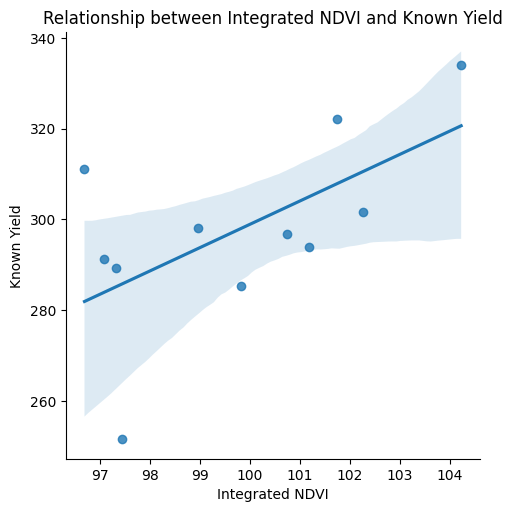

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot with linear regression line
sns.lmplot(x='NDVI', y='Yields', data=df)

# Set plot labels and title
plt.xlabel('Integrated NDVI')
plt.ylabel('Known Yield')
plt.title('Relationship between Integrated NDVI and Known Yield')

# Show plot
plt.show()
